# QEVEC RSE D-Wave tutorial

<b>Goals</b>
- Understand how to (manually) build QUBO/Ising models for real world problems 
    - Objectives
    - Constraints
- Run the quantum annealing using the QUBO/Ising model
- Postprocessing
    - Analyse and display the results
    - Verification (respecting the contraints)
- Use the D-Wave Ocean tools to add constraint to a model
- Use the D-Wave Ocean hybrid methods

## The theory
- Ising vs QUBO
- Eigenproblem
- Objective
- Constraint
- Chain break fraction (majority vote)

### Eigenvalues and eigenvectors

$$
\hat{H}\psi(r) =   \epsilon \ \psi(r)
$$

$$
<\psi(r)|\hat{H}|\psi(r)> =  E
$$

### Binary Quadratic Model

<b>Binary Quadratic Form</b>

<i>Two variables</i>

$$
f(x_{1},x_{2}) = ax_{1}^{2} + bx_{2}^{2} + cx_{1}x_{2} + dx_{1} + ex_{2} + g
$$

$$
x_{1},x_{2} \in {0,1}
$$

$$
f(x_{1},x_{2}) = (a+d)x_{1}^{2} + (b+e)x_{2}^{2} + cx_{1}x_{2} 
$$



<i>N variables</i>

$$
f(x_{1},x_{2}) => f(\mathbf{x})
$$

$$
f(\mathbf{x}) = \mathbf{x}^{T}A\mathbf{x}
$$



<b>Ising</b>

$$
E(s) = \sum_{i} h_{i} s_{i} + \sum_{i,j} J_{i,j} s_{i}s_{j} \ \ \ \ \ s_{i} \in \{+1,-1\}
$$

<b>QUBO (Quadratic Unconstrained Binary Optimisation)</b>
$$
E(x) =   x^{T}Qx = 
    \sum_{i} Q_{i,i} x_{i} + \sum_{i} \sum_{j > i} Q_{i,j} x_{i}x_{j} \ \ \ \ \ x_{i} \in \{0,1\}
    $$

### Solution steps:

- define the system 
- define the model to represent the system (e.g. graph representation)
- map the model representation to a binary array
- express the energy model as an Ising/QUBO model
- run the annealing N times and analyse the results (energy and configuration)

### Example problems:

- <b>Binary</b>
    - Graph partitioning (2 groups)
    - Vacancies in graphene
- <b>Discrete</b>
    - Graph partitioning (3 groups)
    - Travelling salesperson


# Graph partitioning problem
- Group of N people
- Some couples of people are friends
- Divide them in two groups trying to have as many friends in the same group as possible

- Represent the group as a graph
    - each node represents a person
    - each edge (line between nodes) represents the connection between two friends
- Define an energy model that minimises edges between the two groups
| $$x_{i}$$        | $$x_{j}$$           | Energy  |
| --- |---| ---|
| 0 | 0 | 0 |
| 0  | 1  |   1 |
| 1 | 0      |    1 |
| 1 | 1      |    0 |

- $E = x_i + x_j -2x_{i}x_{j}$
- Constraint: same number of people in the two groups

In [1]:
import networkx as nx
from collections import defaultdict
from itertools import combinations
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
from dwave.inspector import show
import math
import numpy as np

### Generate the network

In [11]:
n_people = 6
G = nx.gnp_random_graph(n_people, 0.25) #(N nodes, probability for edge)

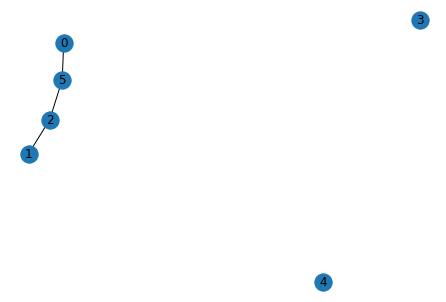

In [18]:
nx.draw(G,with_labels=True)

### QUBO matrix - objective

In [19]:
Q = np.zeros((n_people,n_people))
Q

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [20]:
Q = np.zeros((n_people,n_people))
for i, j in G.edges:
    print(i,j)
    Q[i,i] += 1
    Q[j,j] += 1
    Q[i,j] += -2

0 5
1 2
2 5


In [42]:
#nx.draw(G,with_labels=True)

In [21]:
Q

array([[ 1.,  0.,  0.,  0.,  0., -2.],
       [ 0.,  1., -2.,  0.,  0.,  0.],
       [ 0.,  0.,  2.,  0.,  0., -2.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  2.]])

In [48]:
sampler = EmbeddingComposite(DWaveSampler())
sampleset_qubo = sampler.sample_qubo(Q, num_reads=1000,
                               label='Example - Graph Partitioning - QUBO')

In [49]:
df = sampleset_qubo.to_pandas_dataframe()

,0,1,2,3,4,5,chain_break_fraction,energy,num_occurrences
0,1,1,1,1,1,1,0.0,0.0,140
1,0,0,0,0,0,1,0.0,0.0,100
2,0,1,0,0,0,0,0.0,0.0,202
3,1,0,1,1,1,1,0.0,0.0,61
4,0,1,0,0,0,1,0.0,0.0,220
5,0,0,0,0,0,0,0.0,0.0,104
6,1,0,1,1,1,0,0.0,0.0,58
7,1,1,1,1,1,0,0.0,0.0,115


In [52]:
#nx.draw(G,with_labels=True)

### QUBO matrix - constraint

- Constrain how many people are going to be placed in group 1 ($N_{g1}$)
- Same number of people in the two groups


$$
\sum_{i}^{N_{people}}  x_{i} = N_{g1}
$$
$$
\sum_{i}^{N_{people}}  x_{i} - N_{g1} = 0
$$

$$
\left(\sum_{i}^{N_{people}} x_{i} - N_{g1}\right)^{2} = \\
        \sum_{i}^{N_{people}} x_{i}^{2} + 
        \sum_{i}^{N_{people}}\sum_{j>i}^{N_{people}} 2 x_{i} x_{j} - 
        \sum_{i}^{N_{people}} 2 x_{i} N_{g1} +
        N_{g1}^{2} = \\
        \sum_{i}^{N_{people}} \left(1-2N_{g1}\right) x_{i} +
        \sum_{i}^{N_{people}}\sum_{j>i}^{N_{people}} 2 x_{i} x_{j}
$$

Add a scaling coefficient $\gamma$:

$$
\sum_{i}^{N_{people}} \gamma \left(1-2N_{g1}\right) x_{i} +
        \sum_{i}^{N_{people}}\sum_{j>i}^{N_{people}} 2\gamma x_{i} x_{j}
$$

In [22]:
#Q = np.zeros((n_people,n_people))
gamma = 10
for i in G.nodes:
    Q[i,i] += gamma*(1-2*(0.5*n_people))

for i in range(len(G.nodes)):
    for j in range(i+1,len(G.nodes)):
        Q[(i,j)] += 2*gamma

In [23]:
Q

array([[-49.,  20.,  20.,  20.,  20.,  18.],
       [  0., -49.,  18.,  20.,  20.,  20.],
       [  0.,   0., -48.,  20.,  20.,  18.],
       [  0.,   0.,   0., -50.,  20.,  20.],
       [  0.,   0.,   0.,   0., -50.,  20.],
       [  0.,   0.,   0.,   0.,   0., -48.]])

In [24]:
sampler = EmbeddingComposite(DWaveSampler())
sampleset_qubo_c = sampler.sample_qubo(Q, num_reads=1000,
                               label='Example - Graph Partitioning')

In [25]:
sampleset_qubo_c.to_pandas_dataframe()

,0,1,2,3,4,5,chain_break_fraction,energy,num_occurrences
0,0,1,1,0,1,0,0.000000,-89.0,33
1,0,1,1,1,0,0,0.000000,-89.0,39
2,0,1,1,0,0,1,0.000000,-89.0,49
3,0,1,0,1,1,0,0.000000,-89.0,42
4,1,0,0,1,1,0,0.000000,-89.0,63
5,1,0,0,1,0,1,0.000000,-89.0,78
6,1,0,0,0,1,1,0.000000,-89.0,78
7,1,0,1,0,0,1,0.000000,-89.0,65
8,0,0,1,1,0,1,0.000000,-88.0,30
9,0,0,1,0,1,1,0.000000,-88.0,32


In [62]:
show(sampleset_qubo_c)

'http://127.0.0.1:18000/?problemId=452f9d20-4242-44f1-994f-1877c911f75e'

## Binary Quadratic Model

In [28]:
from dimod import BinaryQuadraticModel

bqm = BinaryQuadraticModel(n_people, vartype='BINARY')

gamma = 10

for i, j in G.edges:
    bqm.add_linear(i,1)
    bqm.add_linear(j,1)
    bqm.add_quadratic(i,j,-2)

bqm.add_linear_equality_constraint(
    [(x,-1) for x in G.nodes],
    constant= 0.5*n_people,
    lagrange_multiplier = gamma,
    )
#bqm.to_numpy_matrix()

In [29]:
sampler = EmbeddingComposite(DWaveSampler())
sampleset = sampler.sample(bqm, num_reads=1000,
                               label='Example - Graph Partitioning- bqm')

In [30]:
sampleset.to_pandas_dataframe()

,0,1,2,3,4,5,chain_break_fraction,energy,num_occurrences
0,1,0,0,1,0,1,0.000000,1.0,64
1,0,1,1,0,0,1,0.000000,1.0,45
2,0,1,0,1,1,0,0.000000,1.0,45
3,1,0,0,0,1,1,0.000000,1.0,72
4,1,0,1,0,0,1,0.000000,1.0,79
5,1,0,0,1,1,0,0.000000,1.0,64
6,0,1,1,0,1,0,0.000000,1.0,45
7,0,1,1,1,0,0,0.000000,1.0,49
8,0,0,1,1,0,1,0.000000,2.0,57
9,0,0,1,1,1,0,0.000000,2.0,63


In [288]:
show(sampleset)      

'http://127.0.0.1:18000/?problemId=78a25d11-4ccd-43d3-b083-dbf275d5c92a'

### Verification
- solutions that respect the constraint

### Parameters
- gamma
- chain strength https://support.dwavesys.com/hc/en-us/community/posts/360016697094-What-is-a-chain-
- anneal time

## Vacancies in graphene

In [120]:
from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor
from ase.visualize import view
import copy

lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  8.685038]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

scaling_matrix = np.array([[3, 0, 0],
                            [0, 3, 0],
                            [0, 0, 1]])

graphene_supercell = copy.deepcopy(graphene)
graphene_supercell.make_supercell(scaling_matrix)
structure = graphene_supercell
num_sites = graphene_supercell.num_sites

In [121]:
shells = np.unique(np.round(graphene_supercell.distance_matrix[0],5)) 
adjacency_matrix = (np.round(graphene_supercell.distance_matrix,5) == shells[1]).astype(int)
#adjacency_matrix

In [122]:
alpha = 1
Q = np.triu(-adjacency_matrix.astype(int),0)

n_vacancies = 1
n_atoms = num_sites - n_vacancies

gamma = 10

for i in range(num_sites):
    Q[i,i] += gamma*(1-2*n_atoms)
    for j in range(i+1,num_sites):
        Q[i,j] += 2*gamma


In [123]:
sampler = EmbeddingComposite(DWaveSampler())
sampleset_graphene = sampler.sample_qubo(Q, num_reads=1000,
                               label='Example - Vacancies in graphene')

In [124]:
df = sampleset_graphene.to_pandas_dataframe()
df.iloc[:,df.columns != 'chain_break_fraction']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,energy,num_occurrences
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,-2914.0,24
1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,-2914.0,15
2,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,-2914.0,23
3,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,-2914.0,11
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,-2914.0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,-2868.0,1
271,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,-2868.0,1
272,1,1,1,1,1,0,1,1,0,1,1,1,1,1,1,1,1,1,-2901.0,1
273,0,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,-2869.0,1


# Graph partitioning problem - 3 groups
- Group of N people
- Some couples of people are friends
- Divide them in three groups (A,B,C) trying to have as many friends in the same group as possible

- Represent the group as a graph
    - each node represents a person
    - each edge (line between nodes) represents the connection between two friends
- Define an energy model that minimises edges between the two groups
| $$x_{i}$$        | $$x_{j}$$           | Energy  |
| --- |---| ---|
| A | A | 0 |
| A  | B  |   1 |
| A | C      |    1 |
| B | B      |    0 |
| B | C      |    1 |
| C | C      |    0 |


- Constraint: same number of people in the three groups

- We cannot use binary variables, we need to define a discrete model
- Binary X vector vs discrete
$$
X = |A B C|=|100,010,001|
$$
<i>NB: the commas are just to help visualise the groups, the actual vector is</i>: |100010001|

- One hot encoding

- $ \sum_{i}^{N_{people}} \left( 1- x_{i_{a}} - x_{i_{b}} - x_{i_{c}}  \right)^{2} = 0    $
- $ \sum_{k}^{N_{groups}} \left(\sum_{i}^{N_{people}} x_{i_{k}} - \frac{N_{people}}{N_{groups}}\right)^{2} = 0   $

In [31]:
n_people = 6
n_groups = 3
people_per_group = n_people/n_groups
G = nx.gnp_random_graph(n_people, 0.5) #(N nodes, probability for edge)

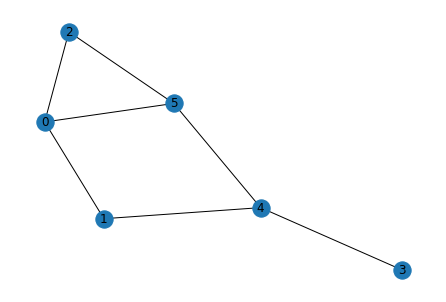

In [32]:
nx.draw(G,with_labels=True)

In [35]:
Q = np.zeros((n_people*n_groups,n_people*n_groups))

num_elements = n_people*n_groups

# Objective
alpha = 1
for i, j in G.edges:
    for k in range(n_groups):        
        for m in range(n_groups):
            Q[(i*n_groups)+k,(j*n_groups)+m]  += 2*alpha
            Q[(i*n_groups)+k,(j*n_groups)+k]  += -1*alpha #This is it!

# One-hot encoding
theta = 10
gamma = 2
for i in range(n_people):
    for k in range(n_groups):
        
        Q[(i*n_groups)+k,(i*n_groups)+k]  +=  -1*theta
        for m in range(k+1,n_groups):
            Q[(i*n_groups)+k,(i*n_groups)+m] += 2*theta

# N people/group constraint
for n in range(n_groups):
    for i in range(n,num_elements,n_groups): 
        Q[i,i] += gamma*(1-2*people_per_group)    
                
for n in range(num_elements):                
    for j in range(n+n_groups,num_elements,n_groups): 
            Q[n,j] += 2*gamma

Q

array([[-16.,  20.,  20.,   3.,   2.,   2.,   3.,   2.,   2.,   4.,   0.,
          0.,   4.,   0.,   0.,   3.,   2.,   2.],
       [  0., -16.,  20.,   2.,   3.,   2.,   2.,   3.,   2.,   0.,   4.,
          0.,   0.,   4.,   0.,   2.,   3.,   2.],
       [  0.,   0., -16.,   2.,   2.,   3.,   2.,   2.,   3.,   0.,   0.,
          4.,   0.,   0.,   4.,   2.,   2.,   3.],
       [  0.,   0.,   0., -16.,  20.,  20.,   4.,   0.,   0.,   4.,   0.,
          0.,   3.,   2.,   2.,   4.,   0.,   0.],
       [  0.,   0.,   0.,   0., -16.,  20.,   0.,   4.,   0.,   0.,   4.,
          0.,   2.,   3.,   2.,   0.,   4.,   0.],
       [  0.,   0.,   0.,   0.,   0., -16.,   0.,   0.,   4.,   0.,   0.,
          4.,   2.,   2.,   3.,   0.,   0.,   4.],
       [  0.,   0.,   0.,   0.,   0.,   0., -16.,  20.,  20.,   4.,   0.,
          0.,   4.,   0.,   0.,   3.,   2.,   2.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0., -16.,  20.,   0.,   4.,
          0.,   0.,   4.,   0.,   2.,   3.,   2.],


In [36]:
sampler = EmbeddingComposite(DWaveSampler())
sampleset_3_groups = sampler.sample_qubo(Q, num_reads=1000,
                               label='Example - Graph Partitioning- discrete')

In [37]:
df = sampleset_3_groups.to_pandas_dataframe()
df.iloc[:,df.columns != 'chain_break_fraction']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,energy,num_occurrences
0,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0,1,0,0,-79.0,3
1,0,1,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,-79.0,4
2,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,-79.0,19
3,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,-79.0,9
4,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,-79.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,-76.0,1
490,0,0,1,1,0,0,0,0,1,0,1,1,0,0,0,1,0,0,-55.0,1
491,0,1,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,1,-58.0,1
492,1,1,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,1,-40.0,1


In [42]:
#nx.draw(G,with_labels=True)

In [40]:
convert_df(df,3,['A','B','C'],remove_unfeasible=True,ts=False)

,0,1,2,3,4,5,chain_break_fraction,energy,num_occurrences
0,C,C,A,B,B,A,0.000000,-79.0,3
1,B,B,C,A,A,C,0.000000,-79.0,4
2,C,C,B,A,A,B,0.000000,-79.0,19
3,A,A,C,B,B,C,0.000000,-79.0,9
4,A,A,B,C,C,B,0.000000,-79.0,9
...,...,...,...,...,...,...,...,...,...
451,B,A,B,B,B,A,0.000000,-60.0,1
453,C,A,C,A,B,B,0.055556,-76.0,1
462,B,B,B,A,C,B,0.055556,-70.0,1
477,A,A,A,A,A,B,0.000000,-54.0,1


## Travelling salesperson
https://www.frontiersin.org/articles/10.3389/fphy.2021.760783/full

In [36]:
cities = ['Amsterdam','London','Warwick','Durham','Glasgow']
cities = ['Amsterdam','London','Warwick']
#cities = ['Amsterdam','London']
distances_miles = {'Amsterdam-London': 330.0, 
             'Amsterdam-Warwick': 434.0,
             'Amsterdam-Durham': 592.0 ,
             'Amsterdam-Glasgow': 602.0,
             'London-Warwick' : 97.6,
             'London-Durham'  : 278.0,
             'London-Glasgow' : 404.0,
             'Warwick-Durham' : 202.0,
             'Warwick-Glasgow': 322.0,
             'Durham-Glasgow' : 162.0,
}

In [207]:
# No normalisation
distances_array = np.array([float(x) for x in distances_miles.values()])
factor = 1
distances = {k: v*factor for k, v in distances_miles.items() }

In [37]:
# Normalise to 1
distances_array = np.array([float(x) for x in distances_miles.values()])
factor = 1/np.linalg.norm(distances_array)
distances = {k: v*factor for k, v in distances_miles.items() }

In [222]:
# Normalise to max
distances_array = np.array([float(x) for x in distances_miles.values()])
factor = 1/np.max(distances_array)
distances = {k: v*factor for k, v in distances_miles.items() }

In [69]:
# One-hot encoding
theta = 0
            
# Cost function
Q = build_interaction_matrix_ts(cities, distances, theta)
np.round(Q,2)

array([[0.  , 0.28, 0.36, 0.  , 0.28, 0.36, 0.  , 0.28, 0.36],
       [0.  , 0.  , 0.08, 0.  , 0.  , 0.08, 0.  , 0.  , 0.08],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.28, 0.36, 0.  , 0.28, 0.36],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.08, 0.  , 0.  , 0.08],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.28, 0.36],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.08],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

In [70]:
x = np.array([1,0,0, 0,1,0, 0,0,1])
#x = np.array([1,0, 0,1])
np.matmul(x,np.matmul(x,Q))
print(np.matmul(x,np.matmul(x,Q)))
np.matmul(x,Q)

0.7202840809215737


array([0.        , 0.27587482, 0.36281719, 0.        , 0.27587482,
       0.44440926, 0.        , 0.27587482, 0.44440926])

In [71]:
x = np.array([0,0,1, 0,1,0, 1,0,0])
#x = np.array([0,1,1,0])
print(np.matmul(x,np.matmul(x,Q)))
np.matmul(x,Q)

0.0


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.08159207, 0.        , 0.27587482, 0.44440926])

In [72]:
#LONG
x = np.array([1,0,0, 0,0,1, 0,1,0])
np.matmul(x,np.matmul(x,Q))
print(np.matmul(x,np.matmul(x,Q)))
np.matmul(x,Q)

0.6386920123306433


array([0.        , 0.27587482, 0.36281719, 0.        , 0.27587482,
       0.36281719, 0.        , 0.27587482, 0.44440926])

In [270]:
sampler = EmbeddingComposite(DWaveSampler())
sampleset_ts = sampler.sample_qubo(Q, num_reads=1000,
                               label='Example - Graph Partitioning- TS')

In [263]:
df = sampleset_ts.to_pandas_dataframe().head(13)

In [271]:
df = sampleset_ts.to_pandas_dataframe()
#print(np.sum(convert_df(df,3,cities,ts=True)['num_occurrences'].to_numpy()))
convert_df(df,3,cities,ts=True)

,0,1,2,chain_break_fraction,energy,num_occurrences
0,Warwick,London,Amsterdam,0.000000,-6.000000,329
1,Warwick,Amsterdam,London,0.000000,-5.837874,288
2,London,Warwick,Amsterdam,0.000000,-5.451827,215
3,London,Amsterdam,Warwick,0.000000,-5.116944,80
4,Amsterdam,Warwick,London,0.000000,-4.730897,20
5,Amsterdam,London,Warwick,0.000000,-4.568771,6
37,Warwick,London,Amsterdam,0.111111,-6.000000,1
40,Warwick,Amsterdam,London,0.111111,-5.837874,1


# Hybrid Solver

## Binary

It allows defining constraints without having to add them to the QUBO matrix or bqm

In [43]:
from dimod import BinaryQuadraticModel, ConstrainedQuadraticModel, Binary, quicksum
from dwave.system import LeapHybridCQMSampler

In [45]:
from dimod import BinaryQuadraticModel

n_people = 6
G = nx.gnp_random_graph(n_people, 0.25)

bqm = BinaryQuadraticModel(n_people, vartype='BINARY')

people = [Binary(i) for i in range(n_people)]

gamma = 10

for i, j in G.edges:
    bqm.add_linear(i,1)
    bqm.add_linear(j,1)
    bqm.add_quadratic(i,j,-2)

cqm = ConstrainedQuadraticModel()
cqm.set_objective(bqm)
cqm.add_constraint(quicksum(people[i] for i in range(n_people)) \
                           == (0.5*n_people), label='Num people')

'Num people'

In [46]:
cqm_sampler = LeapHybridCQMSampler()
result = cqm_sampler.sample_cqm(cqm)

In [47]:
result.to_pandas_dataframe()

,0,1,2,3,4,5,energy,is_feasible,is_satisfied,num_occurrences
0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,True,True,1
1,0.0,1.0,0.0,1.0,0.0,1.0,1.0,True,True,1
2,1.0,0.0,1.0,0.0,0.0,0.0,1.0,False,False,1
3,1.0,0.0,1.0,0.0,1.0,0.0,1.0,True,True,1
4,0.0,1.0,0.0,1.0,0.0,1.0,1.0,True,True,1
5,1.0,0.0,1.0,0.0,1.0,0.0,1.0,True,True,1
6,1.0,0.0,1.0,0.0,1.0,0.0,1.0,True,True,1
7,0.0,1.0,0.0,1.0,0.0,1.0,1.0,True,True,1
8,1.0,0.0,1.0,0.0,1.0,0.0,1.0,True,True,1
9,0.0,1.0,0.0,1.0,0.0,1.0,1.0,True,True,1


## Discrete

In [324]:
 cqm = ConstrainedQuadraticModel()

# Build CQM variables
colors = {n: {c: Binary((n, c)) for c in range(n_groups)} for n in G.nodes}


# Add constraint to make variables discrete
for n in G.nodes():
    print([(n, c) for c in range(n_groups)])
    cqm.add_discrete([(n, c) for c in range(n_groups)])

# Build the constraints: edges have different color end points
for u, v in G.edges:
    for c in range(n_groups):
        cqm.add_constraint(colors[u][c]*colors[v][c] == 0)
cqm

[(0, 0), (0, 1), (0, 2)]
[(1, 0), (1, 1), (1, 2)]
[(2, 0), (2, 1), (2, 2)]
[(3, 0), (3, 1), (3, 2)]
[(4, 0), (4, 1), (4, 2)]
[(5, 0), (5, 1), (5, 2)]


In [332]:
import networkx as nx
import dimod
from dwave.system import LeapHybridDQMSampler

n_people = 3
num_partitions = 3
G = nx.gnp_random_graph(n_people, 0.25)

dqm = dimod.DiscreteQuadraticModel()
num_nodes = G.number_of_nodes()

for i in G.nodes:
    dqm.add_variable(num_partitions, label=i)

'''for i in G.nodes:
    linear_term = 
    dqm.set_linear(i, linear_term)'''

'''# Quadratic term for node pairs that do *not* share edges
for p0, p1 in nx.non_edges(G):
    quadratic_term = ...
    dqm.set_quadratic(p0, p1, {(c, c): quadratic_term for c in range(num_partitions)})
'''
# Quadratic term for node pairs which have edges between them
for p0, p1 in G.edges:
    quadratic_term = -2
    linear_term = 1
    dqm.set_linear(p0, linear_term)
    dqm.set_linear(p1, linear_term)
    dqm.set_quadratic(p0, p1, {(c, c): quadratic_term for c in range(num_partitions)})

# solve!
sampler = LeapHybridDQMSampler()
sampleset = sampler.sample_dqm(dqm, label='Example - Graph Partitioning DQM')

# do something with the lowest-energy solution:
sample = sampleset.first.sample

KeyboardInterrupt: 

In [ ]:
sampleset

In [68]:
def build_interaction_matrix_ts(cities, distances,theta):
    
    #returns an N_sites x N_sites matrix where the i,j element represent the interaction between i and j
    #parameters is a list of list where the 
        # first row represents the first neightbour interaction 
        # second row represents the second neightbour interaction and so on

        #Within the same row, the k-element represent the interaction between species i+j
        #(Think of it as an upper triangular matrix)
        

    num_cities = len(cities)
    num_elements = num_cities**2

    #distance_matrix_filter = np.zeros((num_elements,num_elements),int)


    Q = np.zeros((num_elements,num_elements))
    for i in range(0,num_elements,num_cities):
        for j in range(i,num_elements,num_cities):
            for k in range(num_cities):
                Q[i+k,j+k] = 2*theta #Once per city
                Q[i+k,i+k] = -2*theta #Because there are 2 one-hot encodings
             
                for l in range(k+1,num_cities):
                    Q[i+k,i+l] = 2*theta #one city at a time
    #Objective
    
    #Q = np.zeros((num_elements,num_elements))
    for i in range(num_cities):
        for j in range(i,num_cities):
            for k in range(num_cities):        
                for m in range(num_cities):
                    if k != m:
                        '''if '%s-%s'%(cities[k],cities[m]) in distances:
                            Q[(i*num_cities)+k,(j*num_cities)+m]  = distances['%s-%s'%(cities[i],cities[j])]
                        elif '%s-%s'%(cities[m],cities[k]) in distances:
                            Q[(i*num_cities)+k,(j*num_cities)+m]  = distances['%s-%s'%(cities[i],cities[j])]'''
                        if '%s-%s'%(cities[k],cities[m]) in distances:
                            Q[(i*num_cities)+k,(j*num_cities)+m]  = distances['%s-%s'%(cities[k],cities[m])]
                        #elif '%s-%s'%(cities[m],cities[k]) in distances:
                            #Q[(i*num_cities)+k,(j*num_cities)+m]  = distances['%s-%s'%(cities[m],cities[k])]
                            

    
    return Q
Q = build_interaction_matrix_ts(cities, distances,theta=1)
#np.round(Q,2)

In [32]:
#SAVE
def build_interaction_matrix_ts_old(cities, distances,theta):
    
    #returns an N_sites x N_sites matrix where the i,j element represent the interaction between i and j
    #parameters is a list of list where the 
        # first row represents the first neightbour interaction 
        # second row represents the second neightbour interaction and so on

        #Within the same row, the k-element represent the interaction between species i+j
        #(Think of it as an upper triangular matrix)
        

    num_cities = len(cities)
    num_elements = num_cities**2

    #distance_matrix_filter = np.zeros((num_elements,num_elements),int)


    Q = np.zeros((num_elements,num_elements))
    for i in range(0,num_elements,num_cities):
        for j in range(i,num_elements,num_cities):
            for k in range(num_cities):
                Q[i+k,j+k] = 2*theta
                Q[i+k,i+k] = -2*theta
                for l in range(k+1,num_cities):
                    Q[i+k,i+l] = 2*theta
                    Q[i+k,j+l] = distances['%s-%s'%(cities[k],cities[l])]
                    Q[i+l,j+k] = distances['%s-%s'%(cities[k],cities[l])]

    return Q
Q = build_interaction_matrix_ts(cities, distances,theta=1)
#np.round(build_interaction_matrix_ts(cities, distances,theta=1),2)

In [39]:
def convert_df(dataframe,num_species,name_species,remove_unfeasible=True,ts=False):
    # Convert a discrete df 
    
    import copy

    df = copy.deepcopy(dataframe)

    num_sites = sum([type(x) == int for x in df.columns])
    num_people = int(num_sites/num_species)
    sites = df.iloc[:,0:num_sites].to_numpy()
    
    unf = np.zeros((sites.shape[0],num_people),dtype=int)
    for i in range(sites.shape[0]):
        for j in range(num_people):
            unf[i][j] = np.sum(sites[i,j*num_species:(j+1)*num_species])
    
    unfeasible = np.where(np.prod(unf,axis=1) !=1)[0]

    if ts == True:
        unf = np.zeros((sites.shape[0],num_species),dtype=int)
        
        for i in range(sites.shape[0]):
            for j in range(num_species):
                unf[i][j] = np.sum(sites[i,j::num_species])

        
        unfeasible = np.concatenate((unfeasible,np.where(np.prod(unf,axis=1) !=1)[0]))
        
        unfeasible = np.unique(unfeasible)
                              
    if remove_unfeasible == True:
        df.drop(unfeasible, inplace=True)

    new_labels = df.iloc[:,0:num_sites].to_numpy()[:,::num_species]
    new_labels_arr = df.iloc[:,0:num_sites].to_numpy()
    new_labels = []
    df.drop(np.arange(num_sites),axis=1,inplace=True)
    for line in new_labels_arr:
        new_labels_tmp=  [name_species[x] for x in np.where(line == 1)[0]%num_species]
        #if len(new_labels_tmp) != 6:
            #print(line,new_labels_tmp)
        new_labels.append(new_labels_tmp)

    new_labels = np.array(new_labels)
    
    for i in range(new_labels.shape[1]):
        df.insert(i, i, new_labels[:,i])

    
    return df
#df = sampleset_3_groups.to_pandas_dataframe()
#convert_df(df,3,['A','B','C'])
#convert_df(df,3,['A','B','C'],remove_unfeasible=True,ts=False)

## References
QUBO examples: https://arxiv.org/pdf/1811.11538.pdf